# Лабораторная работа № 8.1

### Задача:

Используя схемы переменных направлений и дробных шагов, решить двумерную
начально-краевую задачу для дифференциального уравнения параболического типа. В
различные моменты времени вычислить погрешность численного решения путем
сравнения результатов с приведенным в задании аналитическим решением
$U(x,t)$.
Исследовать зависимость погрешности от сеточных параметров
$\tau$, $hx$, $hy$.

In [31]:
import math, numpy as np, pandas as pd
import warnings
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import scipy.linalg
from matplotlib import cm
import matplotlib.animation as animation
from IPython.display import HTML
warnings.filterwarnings("ignore", category=DeprecationWarning) 

np.set_printoptions(precision=3)

### Общий вид

$$ \frac{\partial u}{\partial t} = a\frac{\partial^2 u}{\partial x^2} + b\frac{\partial^2 u}{\partial y^2} 
+f(x, y, t) $$

$$ \alpha_{1} u_x(0, y, t) + \beta_{1} u(0, y, t) = \phi_1(y, t) $$
$$ \alpha_{2} u_x(l_x, y, t) + \beta_{2} u(l_x, y, t) = \phi_2(y, t) $$
$$ \alpha_{3} u_y(x, 0, t) + \beta_{3} u(x, 0, t) = \phi_3(x, t) $$
$$ \alpha_{4} u_y(x, l_y, t) + \beta_{4} u(x, l_y, t) = \phi_4(x, t) $$
$$ u(x, y, 0) = \phi_5(x, y) $$

### Условие

$$ \frac{\partial u}{\partial t} = a\frac{\partial^2 u}{\partial x^2} + b\frac{\partial^2 u}{\partial y^2} 
+ sin(x) sin(y) (\mu cos(\mu t) + (a + b)sin(\mu t)) $$

$$ u(0, y, t) = 0 $$
$$ u_x(2\pi, y, t) = sin(y)sin(\mu t) $$
$$ u(x, 0, t) = 0 $$
$$ u_y(x, 2\pi, t) = sin(x)sin(\mu t) $$
$$ u(x, y, 0) = 0 $$

### Аналитическое решение

$$ U(x, y, t) = sin(x)sin(y)sin(\mu t) $$

### Численные методы

In [46]:
a, b, mu = 0.3, 0.3, 6.28

lx, ly, T = 2*np.pi, 2*np.pi, 1.0

f = lambda x, y, t: np.sin(x) * np.sin(y) * (mu * np.cos(mu * t) + (a + b) * np.sin(mu * t))

alpha1, beta1, phi1 = 0.0, 1.0, lambda y, t: 0.0
alpha2, beta2, phi2 = 1.0, 0.0, lambda y, t: np.sin(y)*np.sin(mu * t)
alpha3, beta3, phi3 = 0.0, 1.0, lambda x, t: 0.0
alpha4, beta4, phi4 = 1.0, 0.0, lambda x, t: np.sin(x)*np.sin(mu * t)
phi5 = lambda x, y: 0.0

nx, ny, nT = 40, 40, 100

decision = lambda x, y, t: np.sin(x) * np.sin(y) * np.sin(mu * t)

print(0.5 - ((T / nT) * a / (lx/nx)**2) - ((T / nT) * b / (ly/ny)**2), '>', 0)

0.25682915925838934 > 0


In [47]:
class ADI():
    
    def __init__(self, a, b, lx, ly, T, nx, ny, nT, \
                 alpha1, beta1, phi1, \
                 alpha2, beta2, phi2, \
                 alpha3, beta3, phi3, \
                 alpha4, beta4, phi4, \
                 phi5, f, Lx = 0.0, Ly = 0.0):
        
        self.a, self.b, self.lx, self.ly, self.T, self.nx, self.ny, self.nT, self.f = a, b, lx, ly, T, nx, ny, nT, f
        
        self.alpha1, self.beta1, self.phi1 = alpha1, beta1, phi1
        self.alpha2, self.beta2, self.phi2 = alpha2, beta2, phi2
        self.alpha3, self.beta3, self.phi3 = alpha3, beta3, phi3
        self.alpha4, self.beta4, self.phi4 = alpha4, beta4, phi4
        self.phi5 = phi5
        
        self.Lx, self.Ly = Lx, Ly
        self.hx, self.hy, self.tau = (lx - Lx) / nx, (ly - Ly) / ny, T / nT
        
        self.result = np.ndarray((nT + 1, ny + 1, nx + 1), dtype = np.float32)
        
    def x_i(self, i):
        return self.Lx + self.hx * i
    
    def y_j(self, j):
        return self.Ly + self.hy * j
    
    def t_k(self, k):
        return self.tau * k
    
    def _TMA(self, abc, d):
        if len(d) == 1:
            return [d[0] / abc[1][0]]
        dimension = len(d);
        result = [0 for i in range(dimension)]

        P = [0 for i in range(dimension)]
        Q = [0 for i in range(dimension)]
        P[0] = -(abc[2][0] / abc[1][0])
        Q[0] = (d[0] / abc[1][0])

        for i in range(1, dimension - 1):
            P[i] = -(abc[2][i] / (abc[1][i] + abc[0][i - 1] * P[i - 1]))
            Q[i] = ((d[i] - abc[0][i - 1] * Q[i - 1]) / (abc[1][i] + abc[0][i - 1] * P[i - 1]))


        result[dimension - 1] = ((d[dimension - 1] - abc[0][dimension - 2] * Q[dimension - 2])\
                                 / (abc[1][dimension - 1] + abc[0][dimension - 2] * P[dimension - 2]))

        for i in range(dimension - 1):
            k = dimension - 2 - i
            result[k] = P[k] * result[k + 1] + Q[k]

        return result
        
    def solve(self):
        
        for j in range(self.ny + 1):
            for i in range(self.nx + 1):
                self.result[0][j][i] = self.phi5(self.x_i(i), self.y_j(j))
        
        for k in range(nT):
            
            aa = (-self.a / self.hx**2)
            bb = (2.0 / self.tau) + (2.0 * self.a / self.hx**2)
            gg = (-self.a / self.hx**2)
            
            self.temp = np.ndarray((self.ny + 1, self.nx + 1), dtype = np.float32)
            
            # Заполняем все плоскости по j = 1..ny-1
            for j in range(1, self.ny):
                abc = [[0]*self.nx, [0] * (self.nx + 1), [0]*self.nx]
                d = [0] * (self.nx + 1)
                
                for i in range(self.nx + 1):
                    if i == 0:
                        d[i] = self.phi1(self.y_j(j), self.t_k(k + 0.5))
                    elif i == self.nx: 
                        d[i] = self.phi2(self.y_j(j), self.t_k(k + 0.5))
                    else: 
                        d[i] = (self.b / self.hy**2) * \
                        (self.result[k][j + 1][i] - 2.0 * self.result[k][j][i] + self.result[k][j - 1][i]) + \
                        2.0 / self.tau * self.result[k][j][i] + \
                        self.f(self.x_i(i), self.y_j(j), self.t_k(k + 0.5))
                        
                    if i == 0:
                        abc[1][i] = self.beta1 - self.alpha1 / self.hx
                        abc[2][i] = self.alpha1 / self.hx
                    elif i == self.nx:
                        abc[0][i-1] = - self.alpha2 / self.hx
                        abc[1][i] = self.alpha2 / self.hx + self.beta2
                    else:
                        abc[0][i-1] = aa
                        abc[1][i] = bb
                        abc[2][i] = gg
                        
                rp = self._TMA(abc, d)
                
                for i in range(self.nx + 1):
                    self.temp[j][i] = rp[i]
                    
            # Заполняем плоскости по j = 0 / ny
            for i in range(self.nx + 1):
                self.temp[0][i] = (self.phi3(self.x_i(i), self.t_k(k + 0.5)) -\
                                   self.alpha3 / self.hy * self.temp[1][i]) /\
                (self.beta3 - self.alpha3 / self.hy)
                self.temp[self.ny][i] = (self.phi4(self.x_i(i), self.t_k(k + 0.5)) +\
                                         self.alpha4 / self.hy * self.temp[self.ny-1][i]) /\
                (self.beta4 + self.alpha4 / self.hy)

#                 self.temp[0][i] = (self.phi3(self.x_i(i), self.t_k(k + 0.5)) -\
#                                    (2.0 * self.alpha3 / self.hy) * self.temp[1][i] -\
#                                   (-0.5 * self.alpha3 / self.hy) * self.temp[2][i]) /\
#                 (self.beta3 - 1.5 * self.alpha3 / self.hy)
#                 self.temp[self.ny][i] = (self.phi4(self.x_i(i), self.t_k(k + 0.5)) -\
#                                          (- 2.0 *self.alpha4 / self.hy) * self.temp[self.ny-1][i] -\
#                                         (0.5 *self.alpha4 / self.hy) * self.temp[self.ny-2][i] ) /\
#                 (self.beta4 + 1.5 * self.alpha4 / self.hy)
                
            
            aa = (-self.b / self.hy**2)
            bb = (2.0 / self.tau) + (2.0 * self.b / self.hy**2)
            gg = (-self.b / self.hy**2)
            
            # Заполняем все плоскости по i = 1..nx-1
            for i in range(1, self.nx):
                abc = [[0]*self.ny, [0] * (self.ny + 1), [0]*self.ny]
                d = [0] * (self.ny + 1)
                
                for j in range(self.ny + 1):
                    if j == 0:
                        d[j] = self.phi3(self.x_i(i), self.t_k(k + 1))
                    elif j == self.ny: 
                        d[j] = self.phi4(self.x_i(i), self.t_k(k + 1))
                    else: 
                        d[j] = (self.a / self.hx**2) * \
                        (self.temp[j][i + 1] - 2.0 * self.temp[j][i] + self.temp[j][i - 1]) + \
                        2.0 / self.tau * self.temp[j][i] + \
                        self.f(self.x_i(i), self.y_j(j), self.t_k(k + 0.5))
                        
                    if j == 0:
                        abc[1][j] = self.beta3 - self.alpha3 / self.hy
                        abc[2][j] = self.alpha3 / self.hy
                    elif j == self.ny:
                        abc[0][j-1] = - self.alpha4 / self.hy
                        abc[1][j] = self.alpha4 / self.hy + self.beta4
                    else:
                        abc[0][j-1] = aa
                        abc[1][j] = bb
                        abc[2][j] = gg
                        
                rp = self._TMA(abc, d)
                
                for j in range(self.ny + 1):
                    self.result[k + 1][j][i] = rp[j]
                    
            # Заполняем плоскости по i = 0 / nx
            for j in range(self.ny + 1):
                self.result[k+1][j][0] = (self.phi1(self.y_j(j), self.t_k(k + 1)) -\
                                   self.alpha1 / self.hx * self.result[k+1][j][1]) /\
                (self.beta1 - self.alpha1 / self.hx)
                self.result[k+1][j][self.nx] = (self.phi2(self.y_j(j), self.t_k(k + 1)) +\
                                         self.alpha2 / self.hx * self.result[k+1][j][self.nx-1]) /\
                (self.beta2 + self.alpha2 / self.hx)

#                 self.result[k+1][j][0] = (self.phi1(self.y_j(j), self.t_k(k + 1)) -\
#                                    (2.0 * self.alpha1 / self.hx) * self.result[k+1][j][1] -\
#                                          (-0.5 * self.alpha1 / self.hx) * self.result[k+1][j][2] ) /\
#                 (self.beta1 - 1.5 * self.alpha1 / self.hx)
#                 self.result[k+1][j][self.nx] = (self.phi2(self.y_j(j), self.t_k(k + 1)) -\
#                                          (- 2.0 * self.alpha2 / self.hx) * self.result[k+1][j][self.nx-1] -\
#                                                (0.5 * self.alpha2 / self.hx) * self.result[k+1][j][self.nx-2] ) /\
#                 (self.beta2 + 1.5 * self.alpha2 / self.hx)
        
        return self

In [48]:
adi = ADI(a, b, lx, ly, T, nx, ny, nT, \
          alpha1, beta1, phi1, alpha2, beta2, phi2, alpha3, beta3, phi3, alpha4, beta4, phi4, phi5, f)

adi.solve()

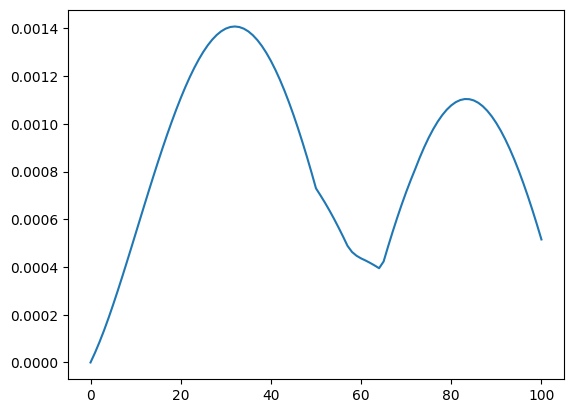

In [49]:
%matplotlib inline

x = np.linspace(0, lx, nx  +1)
y = np.linspace(0, ly, ny  +1)
t = np.linspace(0, T, nT + 1)

y, x, t = np.meshgrid(y, x, t)

plt.plot(np.max(np.abs(decision(x, y, t).T-adi.result),axis=(1,2)))
plt.show()

<IPython.core.display.Javascript object>


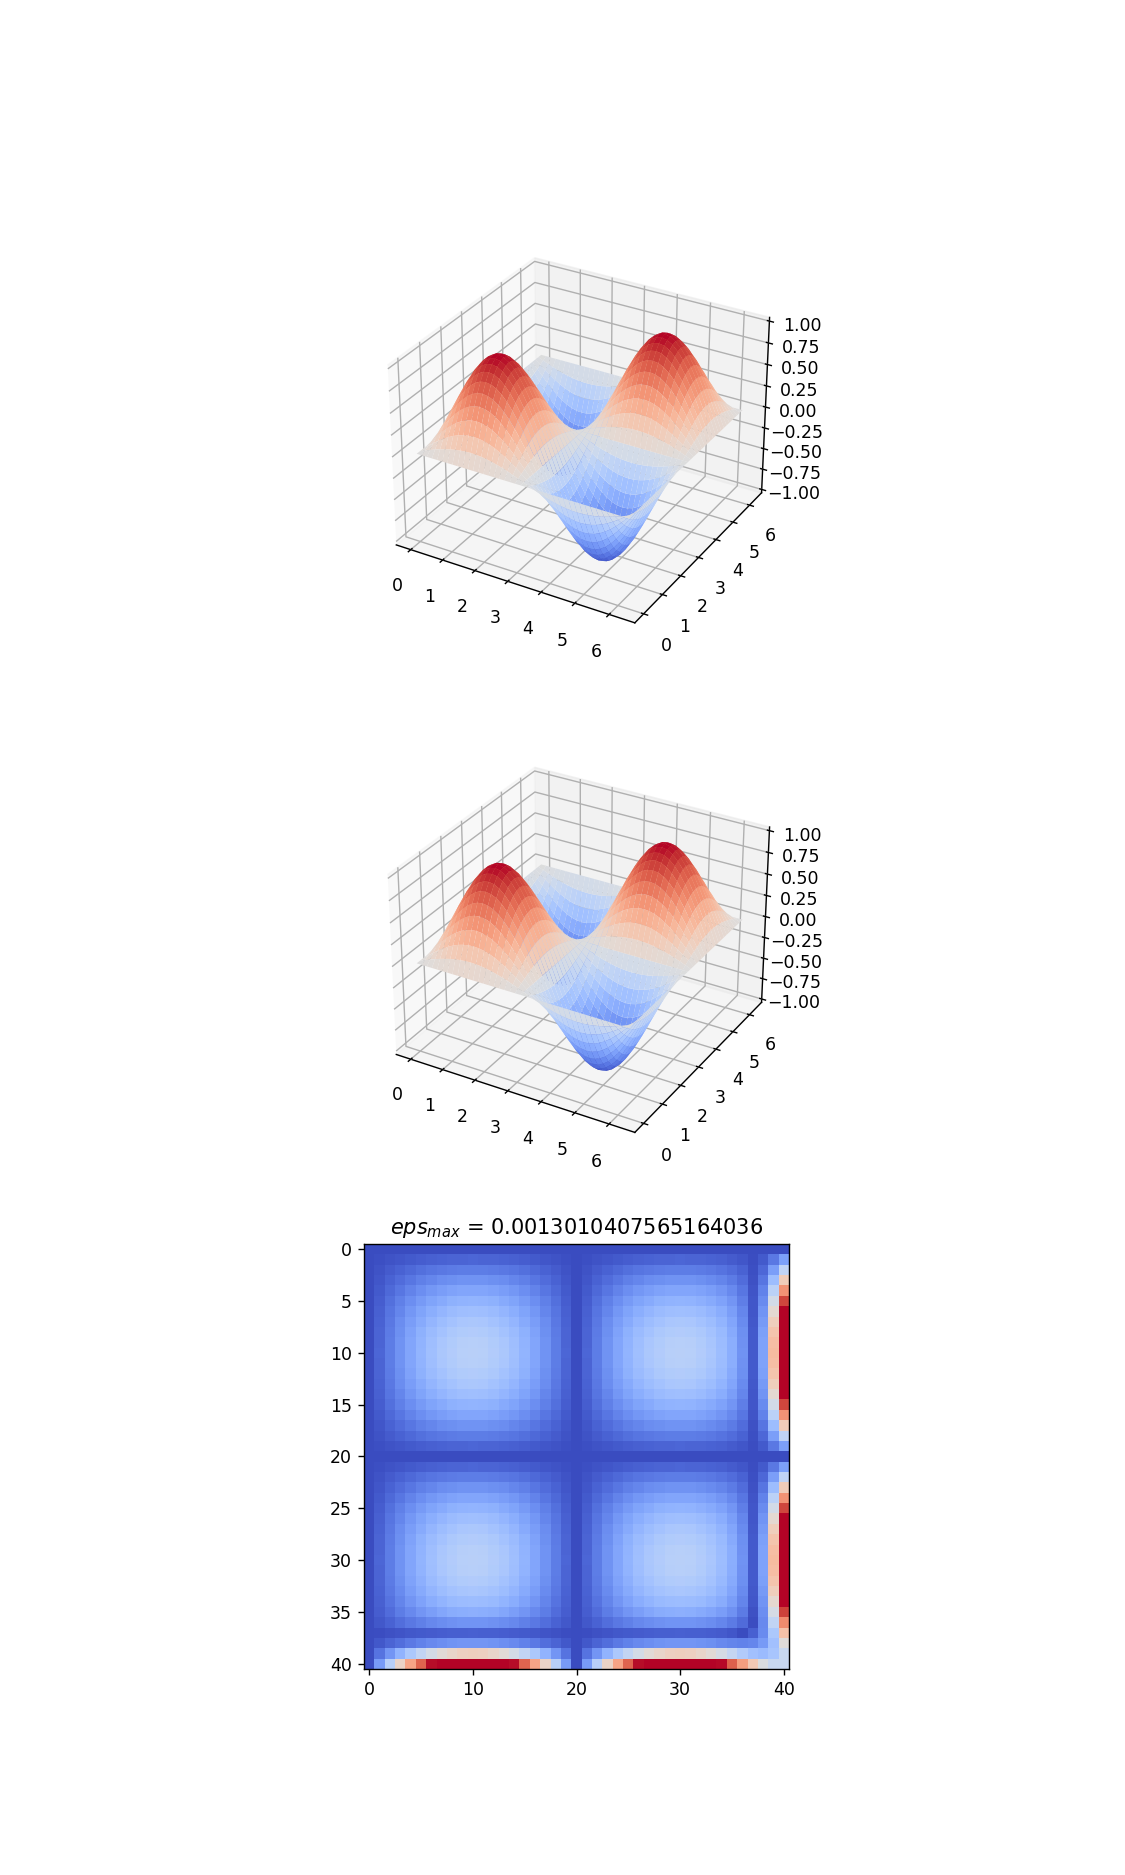

In [50]:
%matplotlib notebook

x = np.linspace(0, lx, nx  +1)
y = np.linspace(0, ly, ny  +1)
t = np.linspace(0, T, nT + 1)
x, y = np.meshgrid(x, y)


fig = plt.figure(figsize=(9,15))
ax1 = plt.subplot(311, projection='3d')
ax2 = plt.subplot(312, projection='3d')
ax3 = plt.subplot(313)

def animate(i):
    ax1.clear()
    ax1.set_zlim(-1, 1)
    ax2.clear()
    ax2.set_zlim(-1, 1)
    ax3.clear()
    
    line1 = ax1.plot_surface(x, y, adi.result[i], cmap=cm.coolwarm, linewidth=0)
    line2 = ax2.plot_surface(x, y, decision(x, y, adi.t_k(i)), cmap=cm.coolwarm, linewidth=0)
    line3 = ax3.imshow(np.abs(decision(x, y, adi.t_k(i))-adi.result[i]), cmap=cm.coolwarm, vmax=0.001)
    ax3.set_title(f"$eps_{{max}}$ = {np.max(np.abs(decision(x, y, adi.t_k(i))-adi.result[i]))}")
    
    return ax1, ax2, ax3

sin_animation = animation.FuncAnimation(fig, 
                                      animate, 
                                      frames=[i for i in range(nT + 1)],
                                      interval = 10)

plt.show()

In [37]:
class FSM():
    
    def __init__(self, a, b, lx, ly, T, nx, ny, nT, \
                 alpha1, beta1, phi1, \
                 alpha2, beta2, phi2, \
                 alpha3, beta3, phi3, \
                 alpha4, beta4, phi4, \
                 phi5, f):
        
        self.a, self.b, self.lx, self.ly, self.T, self.nx, self.ny, self.nT, self.f = a, b, lx, ly, T, nx, ny, nT, f
        
        self.alpha1, self.beta1, self.phi1 = alpha1, beta1, phi1
        self.alpha2, self.beta2, self.phi2 = alpha2, beta2, phi2
        self.alpha3, self.beta3, self.phi3 = alpha3, beta3, phi3
        self.alpha4, self.beta4, self.phi4 = alpha4, beta4, phi4
        self.phi5 = phi5
        
        self.hx, self.hy, self.tau = lx / nx, ly / ny, T / nT
        
        self.result = np.ndarray((nT + 1, ny + 1, nx + 1), dtype = np.float32)
        
    def x_i(self, i):
        return self.hx * i
    
    def y_j(self, j):
        return self.hy * j
    
    def t_k(self, k):
        return self.tau * k
    
    def _TMA(self, abc, d):
        if len(d) == 1:
            return [d[0] / abc[1][0]]
        dimension = len(d);
        result = [0 for i in range(dimension)]

        P = [0 for i in range(dimension)]
        Q = [0 for i in range(dimension)]
        P[0] = -(abc[2][0] / abc[1][0])
        Q[0] = (d[0] / abc[1][0])

        for i in range(1, dimension - 1):
            P[i] = -(abc[2][i] / (abc[1][i] + abc[0][i - 1] * P[i - 1]))
            Q[i] = ((d[i] - abc[0][i - 1] * Q[i - 1]) / (abc[1][i] + abc[0][i - 1] * P[i - 1]))


        result[dimension - 1] = ((d[dimension - 1] - abc[0][dimension - 2] * Q[dimension - 2])\
                                 / (abc[1][dimension - 1] + abc[0][dimension - 2] * P[dimension - 2]))

        for i in range(dimension - 1):
            k = dimension - 2 - i
            result[k] = P[k] * result[k + 1] + Q[k]

        return result
        
    def solve(self):
        
        for j in range(self.ny + 1):
            for i in range(self.nx + 1):
                self.result[0][j][i] = self.phi5(self.x_i(i), self.y_j(j))
        
        for k in range(nT):
            
            aa = (-self.a / self.hx**2)
            bb = (1.0 / self.tau) + (2.0 * self.a / self.hx**2)
            gg = (-self.a / self.hx**2)
            
            self.temp = np.ndarray((self.ny + 1, self.nx + 1), dtype = np.float32)
            
            # Заполняем все плоскости по j = 0..ny
            for j in range(self.ny + 1):
                abc = [[0]*self.nx, [0] * (self.nx + 1), [0]*self.nx]
                d = [0] * (self.nx + 1)
                
                for i in range(self.nx + 1):
                    if i == 0:
                        d[i] = self.phi1(self.y_j(j), self.t_k(k + 0.5))
                    elif i == self.nx: 
                        d[i] = self.phi2(self.y_j(j), self.t_k(k + 0.5))
                    else: 
                        d[i] = 1.0 / self.tau * self.result[k][j][i] + \
                        self.f(self.x_i(i), self.y_j(j), self.t_k(k)) / 2.0
                        
                    if i == 0:
                        abc[1][i] = self.beta1 - self.alpha1 / self.hx
                        abc[2][i] = self.alpha1 / self.hx
                    elif i == self.nx:
                        abc[0][i-1] = - self.alpha2 / self.hx
                        abc[1][i] = self.alpha2 / self.hx + self.beta2
                    else:
                        abc[0][i-1] = aa
                        abc[1][i] = bb
                        abc[2][i] = gg
                        
                rp = self._TMA(abc, d)
                
                for i in range(self.nx + 1):
                    self.temp[j][i] = rp[i]
            
            aa = (-self.b / self.hy**2)
            bb = (1.0 / self.tau) + (2.0 * self.b / self.hy**2)
            gg = (-self.b / self.hy**2)
            
            # Заполняем все плоскости по i = 0..nx
            for i in range(self.nx + 1):
                abc = [[0]*self.ny, [0] * (self.ny + 1), [0]*self.ny]
                d = [0] * (self.ny + 1)
                
                for j in range(self.ny + 1):
                    if j == 0:
                        d[j] = self.phi3(self.x_i(i), self.t_k(k + 1))
                    elif j == self.ny: 
                        d[j] = self.phi4(self.x_i(i), self.t_k(k + 1))
                    else: 
                        d[j] = 1.0 / self.tau * self.temp[j][i] + \
                        self.f(self.x_i(i), self.y_j(j), self.t_k(k + 1)) / 2.0
                        
                    if j == 0:
                        abc[1][j] = self.beta3 - self.alpha3 / self.hy
                        abc[2][j] = self.alpha3 / self.hy
                    elif j == self.ny:
                        abc[0][j-1] = - self.alpha4 / self.hy
                        abc[1][j] = self.alpha4 / self.hy + self.beta4
                    else:
                        abc[0][j-1] = aa
                        abc[1][j] = bb
                        abc[2][j] = gg
                        
                rp = self._TMA(abc, d)
                
                for j in range(self.ny + 1):
                    self.result[k + 1][j][i] = rp[j]
        
        return self

In [38]:
fsm = FSM(a, b, lx, ly, T, nx, ny, nT, \
          alpha1, beta1, phi1, alpha2, beta2, phi2, alpha3, beta3, phi3, alpha4, beta4, phi4, phi5, f)

fsm.solve()

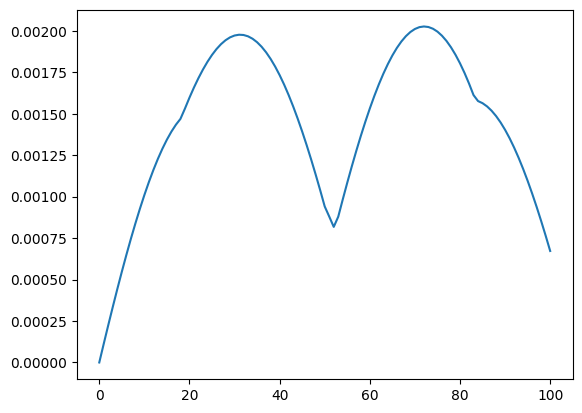

In [39]:
%matplotlib inline

x = np.linspace(0, lx, nx  +1)
y = np.linspace(0, ly, ny  +1)
t = np.linspace(0, T, nT + 1)

y, x, t = np.meshgrid(y, x, t)

plt.plot(np.max(np.abs(decision(x, y, t).T-fsm.result),axis=(1,2)))
plt.show()

<IPython.core.display.Javascript object>


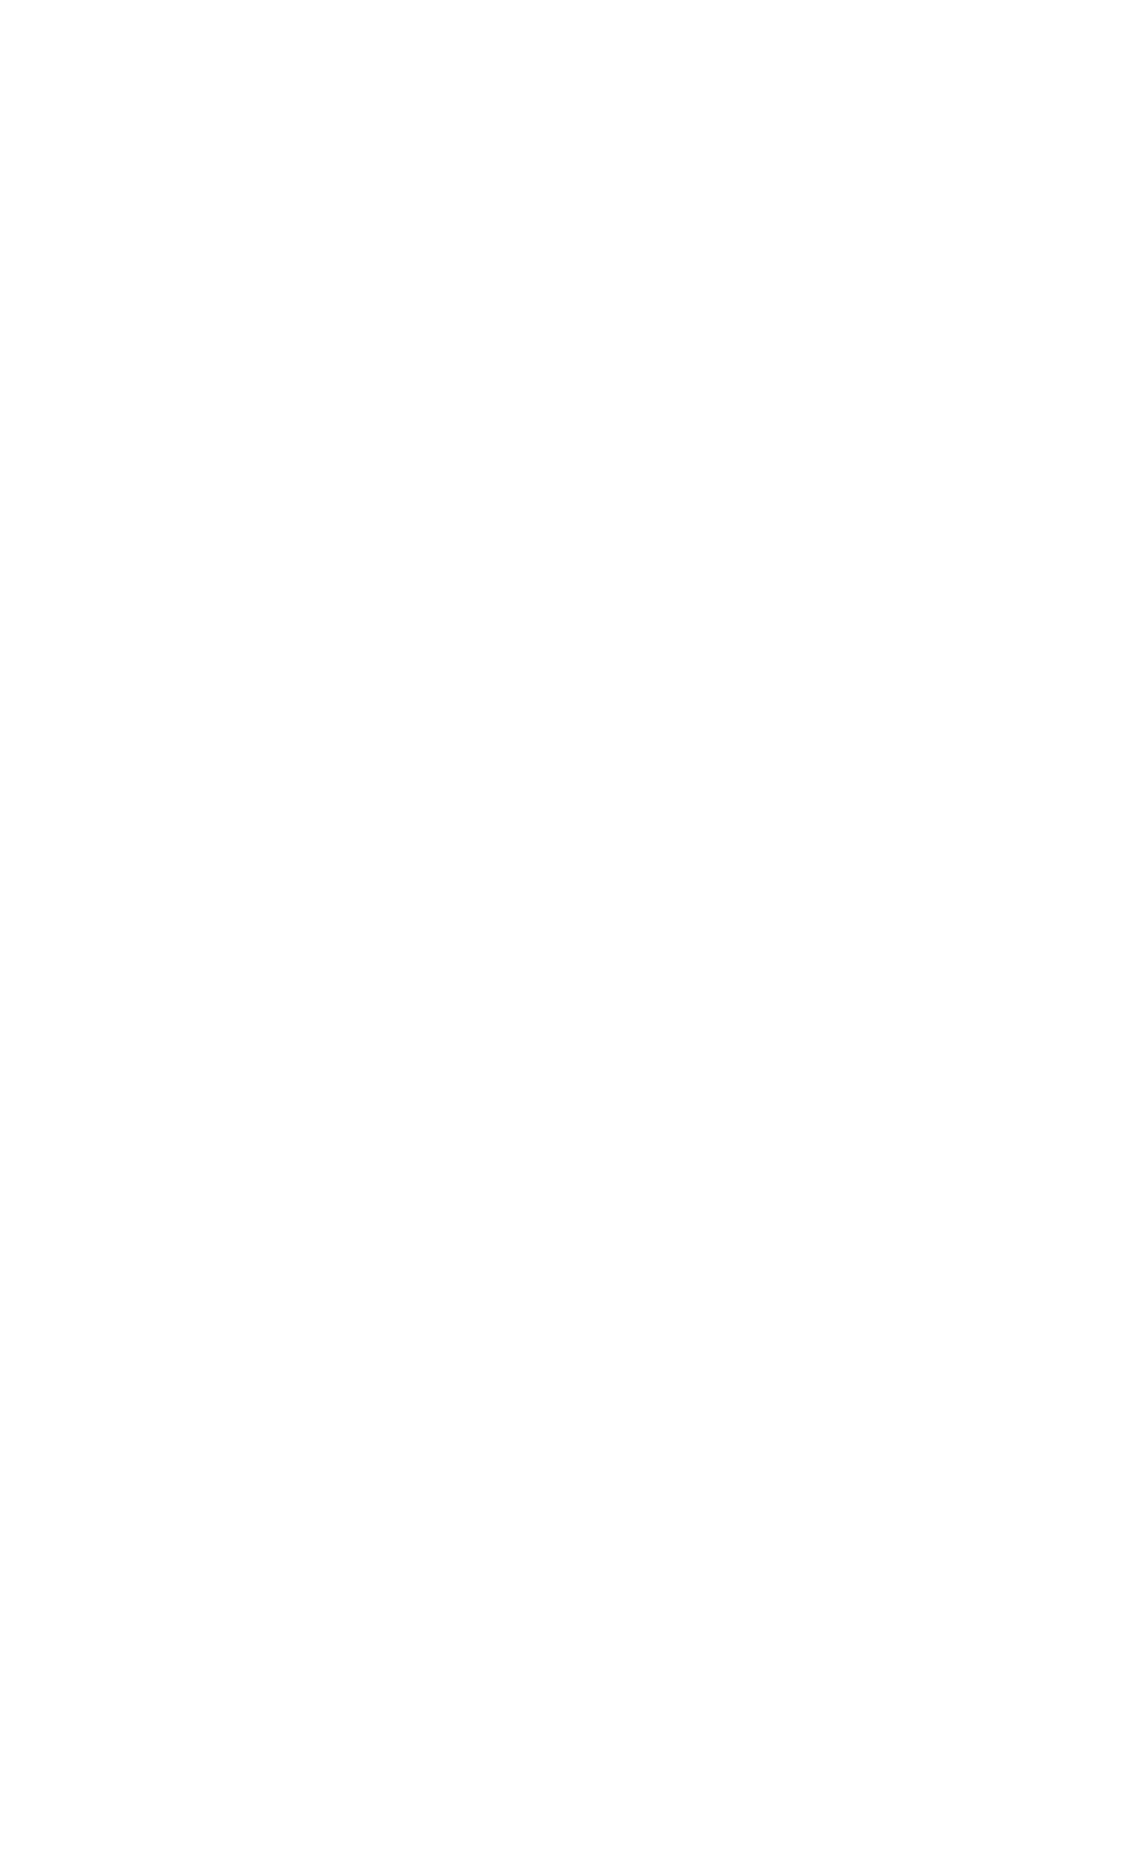

In [40]:
%matplotlib notebook

x = np.linspace(0, lx, nx  +1)
y = np.linspace(0, ly, ny  +1)
t = np.linspace(0, T, nT + 1)
x, y = np.meshgrid(x, y)


fig = plt.figure(figsize=(9,15))
ax1 = plt.subplot(311, projection='3d')
ax2 = plt.subplot(312, projection='3d')
ax3 = plt.subplot(313)

def animate(i):
    ax1.clear()
    ax1.set_zlim(-1, 1)
    ax2.clear()
    ax2.set_zlim(-1, 1)
    ax3.clear()
    
    line1 = ax1.plot_surface(x, y, fsm.result[i], cmap=cm.coolwarm, linewidth=0)
    line2 = ax2.plot_surface(x, y, decision(x, y, fsm.t_k(i)), cmap=cm.coolwarm, linewidth=0)
    line3 = ax3.imshow(np.abs(decision(x, y, adi.t_k(i))-fsm.result[i]), cmap=cm.coolwarm, vmax=0.001)
    ax3.set_title(f"$eps_{{max}}$ = {np.max(np.abs(decision(x, y, fsm.t_k(i))-fsm.result[i]))}")
    
    return ax1, ax2, ax3

sin_animation = animation.FuncAnimation(fig, 
                                      animate, 
                                      frames=[i for i in range(nT + 1)],
                                      interval = 10)

plt.show()

In [86]:
a, b = 0.718, 0.03

lx, ly, T = 1.0, 1.0, 0.05

f = lambda x, y, t: 0.0

alpha1, beta1, phi1 = 0.0, 1.0, lambda y, t: 0.0
alpha2, beta2, phi2 = 0.0, 1.0, lambda y, t: 0.0
alpha3, beta3, phi3 = 0.0, 1.0, lambda x, t: 0.0
alpha4, beta4, phi4 = 0.0, 1.0, lambda x, t: 0.0
phi5 = lambda x, y: 10.0 if x == 0.0 and y == 0.0 else 0.0

nx, ny, nT = 40, 40, 10

print(0.5 - ((T / nT) * a / (lx/nx)**2) - ((T / nT) * b / (ly/ny)**2), '>', 0)

-5.483999999999999 > 0


In [87]:
adi = ADI(a, b, lx, ly, T, nx, ny, nT, \
          alpha1, beta1, phi1, alpha2, beta2, phi2, alpha3, beta3, phi3, alpha4, beta4, phi4, phi5, f, -1.0, -1.0)

adi.solve()

<IPython.core.display.Javascript object>


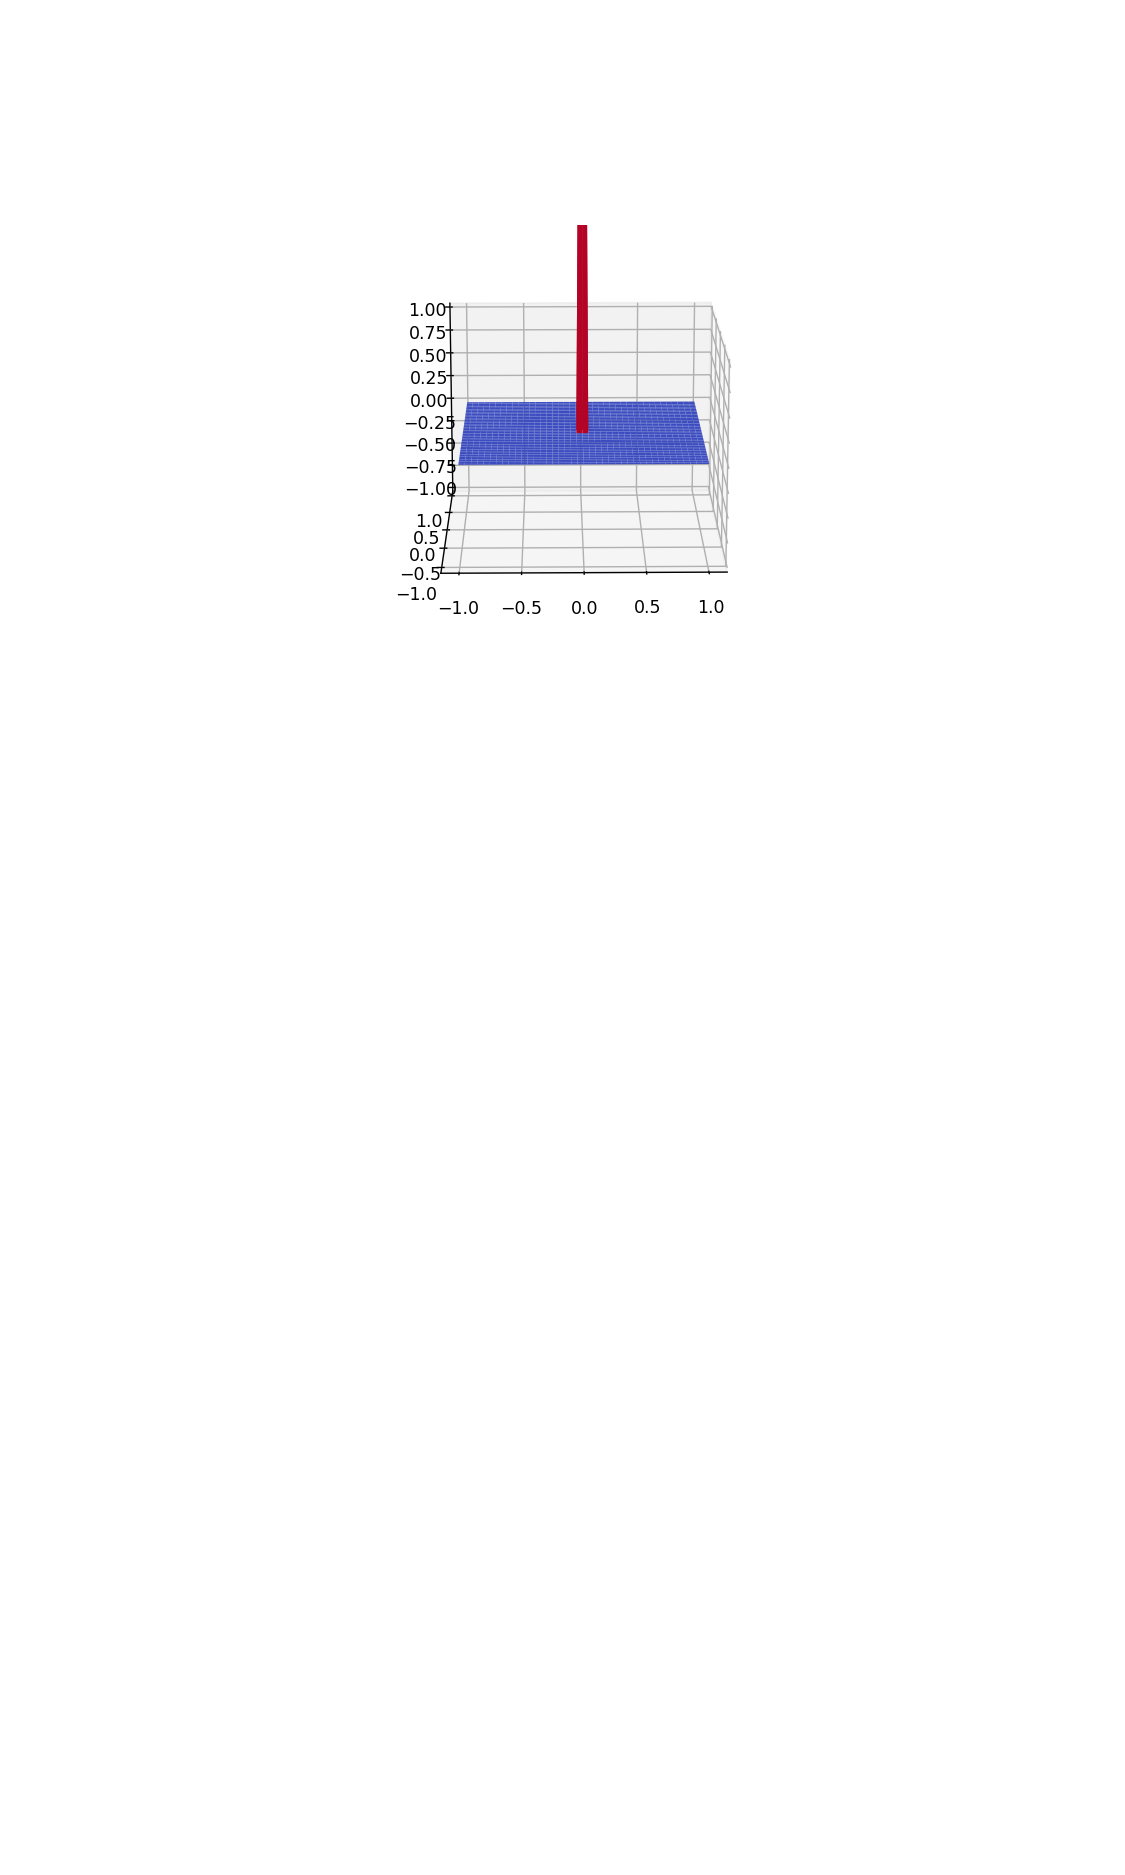

In [88]:
%matplotlib notebook

x = np.linspace(-1.0, lx, nx + 1)
y = np.linspace(-1.0, ly, ny + 1)
t = np.linspace(0, T, nT + 1)
x, y = np.meshgrid(x, y)


fig = plt.figure(figsize=(9,15))
ax1 = plt.subplot(311, projection='3d')

def animate(i):
    ax1.clear()
    ax1.set_zlim(-1, 1)
    
    line1 = ax1.plot_surface(x, y, adi.result[i], cmap=cm.coolwarm, linewidth=0)
    
    return ax1

sin_animation = animation.FuncAnimation(fig, 
                                      animate, 
                                      frames=[i for i in range(nT + 1)],
                                      interval = 1000)

plt.show()